In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nw
import json

import clean

In [2]:
train_raw  = json.load(open('data/train.json', 'r'))

In [3]:
# df = clean.parse_json_to_df('data/raw.json')
df = pd.DataFrame(train_raw)

In [4]:
def strip_string_from_attr(attr, key):
    return str(' '.join(attr[key])) \
        if attr.has_key(key) else ''

In [5]:
df = df[~df['ingredients'].isnull()]
# df['course'] = df.attributes.apply(strip_string_from_attr, args=['course'])
# df['cuisine'] = df.attributes.apply(strip_string_from_attr, args=['cuisine'])


In [6]:
# sum(df['course'] != '')

In [7]:
sum(df['cuisine'] != '')

39774

In [8]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


# Predict Courses!

Generate a train-test split (70% vs 30%).

In [19]:
df_all = df[df['cuisine']!= ''].reset_index()
from sklearn.cross_validation import ShuffleSplit
train_ind, test_ind = ShuffleSplit(len(df_all), n_iter=1, test_size=0.3).__iter__().next()
df_train = df_all.loc[train_ind]
df_test = df_all.loc[test_ind]


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
vect = CountVectorizer(min_df=2)

In [25]:
x_train = vect.fit_transform(df_train['ingredients'].apply(lambda l: ' '.join(l)))
x_test = vect.transform(df_test[])

In [53]:
from sklearn.preprocessing import LabelBinarizer
la = LabelBinarizer()
Y = la.fit_transform(df_all['cuisine'])
Y_train = Y[train_ind]
Y_test =  Y[test_ind]

In [13]:
x.shape

(27841, 2284)

27841


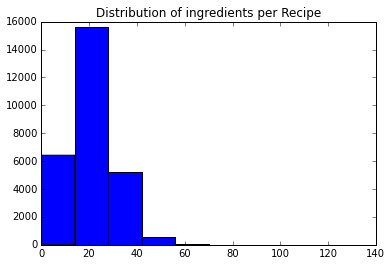

In [22]:
# sum the counts across rows
row_sums = np.sum(x.A, axis=1)
print len(row_sums)
plt.hist(row_sums)
plt.title("Distribution of ingredients per Recipe")

2284


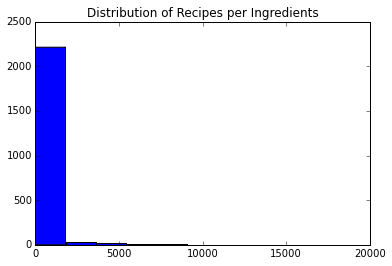

In [23]:
# sum the counts across cols
col_sums = np.sum(x.A, axis=0)
print len(col_sums)
plt.hist(col_sums)
plt.title("Distribution of Recipes per Ingredients")

In [14]:
def barh_label_score(labels, scores):
    labels = np.array(labels)
    scores = np.array(scores)
    sorted_idx = np.argsort(scores)
    pos = np.arange(sorted_idx.shape[0]) + 3.
    plt.figure(figsize=(5,15))
    plt.barh(pos, scores[sorted_idx], align='center')
    plt.yticks(pos, labels[sorted_idx])



In [16]:
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
labels = []
vals = []

for g, df_g in df_train.groupby('cuisine'):
    labels.append(g)
    vals.append(len(df_g))
#     print g, len(df_g)

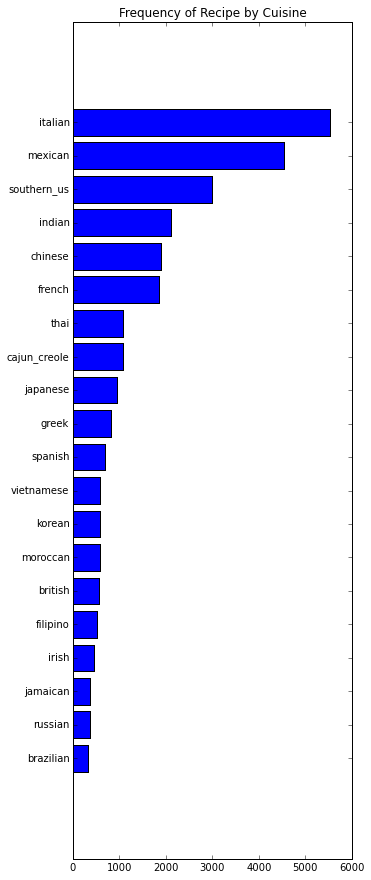

In [17]:

barh_label_score(labels, vals)
plt.title('Frequency of Recipe by Cuisine')

In [24]:
from sklearn.svm import SVC

In [27]:
svc = SVC()
svc.fit(x_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [139]:
x_test = vect.transform(df_test['ingredients'].apply(lambda l: ' '.join(l)))
y_pred_svm = svc.predict(x_test)

## Tensor Flow Experiment

In [59]:
import tensorflow as tf
import random

In [74]:
random.sample([1,2,3], 2)

[3, 2]

In [147]:
def train_nn(x_train, y_train):
    n, p = x_train.shape
    print n,p
    n,k = y_train.shape
    x = tf.placeholder(tf.float32, [None, p])
    # initialize tensors
    W = tf.Variable(tf.zeros([p, k]))
    b = tf.Variable(tf.zeros([k]))
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    y_ = tf.placeholder(tf.float32, [None, k])
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    # use gradient descent to optimize for cross entropy
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    for i in range(1000):
        # train on a portion of the time (much faster)
        batch_index = np.random.random_integers(0, n-1, int(n/10))

        sess.run(train_step, feed_dict={x: x_train[batch_index, :], y_: y_train[batch_index]})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    prediction = tf.nn.softmax(tf.matmul(x, W) + b)
    return sess, prediction, x, y_

In [34]:
# Y_train.shape = (len(Y_train),1)
# print Y_train.shape

(27841, 1)


In [57]:
x_train.A.shape

(27841, 2255)

In [148]:
sess, pred, x, y_ = train_nn(x_train.A, Y_train)


27841 2255


In [152]:
Y_pred_nn= sess.run(tf.argmax(pred,1), feed_dict={x: x_test.A, y_: Y_test})

(array([  151.,   329.,   378.,   467.,  9111.,   593.,   279.,   390.,
          197.,    38.]),
 array([-18. , -14.3, -10.6,  -6.9,  -3.2,   0.5,   4.2,   7.9,  11.6,
         15.3,  19. ]),
 <a list of 10 Patch objects>)

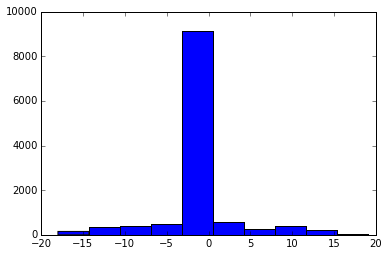

In [154]:
plt.hist(np.argmax(Y_test,1) - Y_pred_nn)


In [156]:
from sklearn.metrics import accuracy_score
print 'SVM Accuracy:', accuracy_score(np.argmax(Y_test,1), y_pred_svm)
print 'Perceptron Accuracy:', accuracy_score(np.argmax(Y_test,1), Y_pred_nn)

SVM Accuracy: 0.544037542948
Perceptron Accuracy: 0.73334450683
